# High level view of the workflow
* Get data ready (turn into tensors)
* Build or pick a pretrained model which suits our problem
    * Pick a loss function & optimizer
    * Build a training loop
* Fit the model to the data and make a prediction
* Evaluate the model
* Improve through experimentation
* Save and reload the trained model

Resources:
* https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb

In [205]:
import torch
from torch import nn # all of PyTorch's neural network modules
import matplotlib.pyplot as plt

torch.__version__, torch.cuda.is_available()

('2.9.1+cu130', True)

## 1. Data preparing and loading

Can come in any form:
* Spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

In [206]:
# Create some known data using linear regression

# Known parameters
weight = 0.7
bias = 0.3

# Create features and labels
start = 0
end = 1
step = 0.02
X = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1) # features
y = weight * X + bias # labels

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [207]:
len(X), len(y)

(50, 50)

In [208]:
### Split data into training and test sets
train_split = int(0.8 * len(X)) # 80% of data for training
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualize the data

In [209]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions to ground truth labels.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Plot predictions if they exist
    if predictions is not None:
        # Plot predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

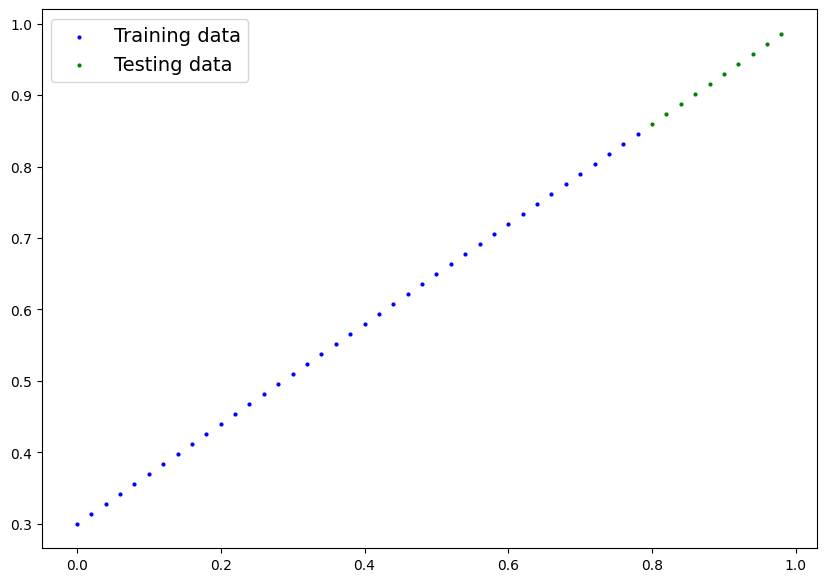

In [210]:
plot_predictions()

## 2. Build model

* Start with random values of weight and bias
* Look at training data and adjust the random values to get closer to the ideal values

The process:
1. Gradient descent
2. Backpropagation

In [211]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # almost every PyTorch model subclasses nn.Module, the base class for all neural network modules
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # start with random weights
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # start with random bias
        # Note: requires_grad=True means PyTorch will track gradients with respect to these parameters during backpropagation

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
        return self.weights * x + self.bias # linear regression formula

### PyTorch model building essentials

* torch.nn: all of the building blocks for computational graphs (which covers neural networks)
* torch.nn.Parameter: what parameters our model should try and learn, often a PyTorch layer from torch.nn sets these
* torch.nn.Module: base class for all NN models. If subclassed, overwrite `forward`
* torch.optim: where optimizers in PyTorch live; they help with gradient descent
* def forward(): all nn.Module subclasses are required to overwrite this. It defines what happens in forward computation
* torch.utils.data.Dataset: map between key (label) and sample (features) pairs of the data
* torch.utils.data.DataLoader: creates Python iterable over a torch Dataset

### Checking contents of PyTorch model

Create an instance of the class and check contents.

Check model parameters using `.parameters()`

In [212]:
# Create a manual seed
torch.manual_seed(42)

# Instantiate the model
model_0 = LinearRegressionModel()
model_0, model_0.weights, model_0.bias

(LinearRegressionModel(),
 Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True))

In [213]:
# List the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [214]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

Check how well it predicts `y_test` based on `x_test`

The model passes our data through the `forward` method

In [215]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [216]:
# Make prediction
with torch.inference_mode(): # inference mode is a context manager that disables gradient tracking
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [217]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

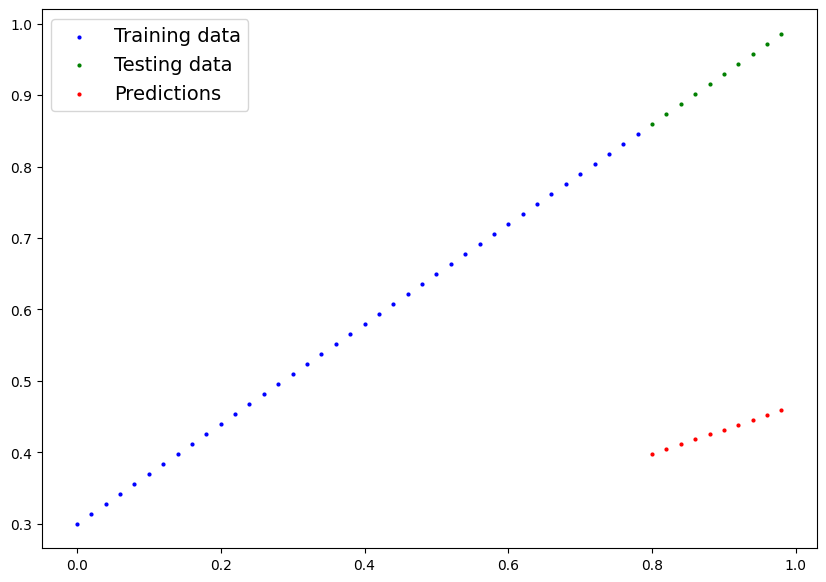

In [218]:
plot_predictions(predictions=y_preds)

## 3. Train the model

Move from some (unknown) parameters to known/expected parameters, or from a poor representation of the data to a better representation of the data

One way to measure the accuracy of the model is to use a **Loss function**.

**Optimizer** takes into account the loss of a model and adjusts the model's parameters (weights and biases) to reduce the loss.

For PyTorch, we need:
- A training loop
- A testing loop

In [219]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [220]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [221]:
# Set up a loss function
Loss_fn = nn.L1Loss() # Mean Absolute Error (MAE)

# Set up an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001) # Stochastic Gradient Descent (SGD)

### Building training loop and testing loop in PyTorch

What we need in training loop:

0. Loop through the data
1. Forward pass/propagation (data is taken through `forward` method)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - Use the optimizer to adjust our model's parameter to try and improve the loss (**gradient descent**)

In [222]:
# Init results for observation (store actual values, not references)
results = []
params = list(model_0.parameters())
results.append((params[0].item(), params[1].item()))

In [ ]:
# torch.manual_seed(42)

# 1 epoch is one loop through the data
epochs = 1500 # Actually converges around 1750

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # sets all parameters with require_grad=True to require gradients

    # 1. Forward pass
    y_pred = model_0.forward(X_train)

    # 2. Calculate the loss
    loss = Loss_fn(y_pred, y_train)
    print(f"Loss: {loss}")

    # 3. Optimizer zero grad, clear old gradients
    optimizer.zero_grad()

    # 4. Backpropagation on the loss wrt the parameters of the model, compute new gradients
    loss.backward()

    # 5. Step the optimizer (perform gradient descent), update parameters
    optimizer.step() # by default, how the optimizer changes will accumulate through the loop, so zero them at the start of the next iteration (step 3)

    # Save to results
    params = list(model_0.parameters())
    results.append((params[0].item(), params[1].item()))
    ### Testing
    # model_0.eval() 

Loss: 0.31288138031959534
Loss: 0.3117292523384094
Loss: 0.3105771541595459
Loss: 0.3094250559806824
Loss: 0.30827295780181885
Loss: 0.3071208596229553
Loss: 0.3059687614440918
Loss: 0.3048166334629059
Loss: 0.30366456508636475
Loss: 0.3025124669075012
Loss: 0.3013603389263153
Loss: 0.30020827054977417
Loss: 0.29905614256858826
Loss: 0.2979040741920471
Loss: 0.2967519462108612
Loss: 0.29559987783432007
Loss: 0.29444774985313416
Loss: 0.293295681476593
Loss: 0.2921435832977295
Loss: 0.2909914553165436
Loss: 0.28983938694000244
Loss: 0.28868725895881653
Loss: 0.287535160779953
Loss: 0.2863830626010895
Loss: 0.28523099422454834
Loss: 0.2840788662433624
Loss: 0.2829267382621765
Loss: 0.281774640083313
Loss: 0.28062254190444946
Loss: 0.2794705033302307
Loss: 0.2783183455467224
Loss: 0.2771662771701813
Loss: 0.27601414918899536
Loss: 0.2748620808124542
Loss: 0.2737099528312683
Loss: 0.2725578844547272
Loss: 0.27140578627586365
Loss: 0.2702536880970001
Loss: 0.2691015899181366
Loss: 0.2679494

In [224]:
print("Results (weight, bias):")
for i, (w, b) in enumerate(results):
    print(f"Step {i}: weight={w:.4f}, bias={b:.4f}")

print(f"\nTarget: weight={weight}, bias={bias}")

Results (weight, bias):
Step 0: weight=0.3367, bias=0.1288
Step 1: weight=0.3371, bias=0.1298
Step 2: weight=0.3375, bias=0.1308
Step 3: weight=0.3379, bias=0.1318
Step 4: weight=0.3383, bias=0.1328
Step 5: weight=0.3386, bias=0.1338
Step 6: weight=0.3390, bias=0.1348
Step 7: weight=0.3394, bias=0.1358
Step 8: weight=0.3398, bias=0.1368
Step 9: weight=0.3402, bias=0.1378
Step 10: weight=0.3406, bias=0.1388
Step 11: weight=0.3410, bias=0.1398
Step 12: weight=0.3414, bias=0.1408
Step 13: weight=0.3418, bias=0.1418
Step 14: weight=0.3422, bias=0.1428
Step 15: weight=0.3425, bias=0.1438
Step 16: weight=0.3429, bias=0.1448
Step 17: weight=0.3433, bias=0.1458
Step 18: weight=0.3437, bias=0.1468
Step 19: weight=0.3441, bias=0.1478
Step 20: weight=0.3445, bias=0.1488
Step 21: weight=0.3449, bias=0.1498
Step 22: weight=0.3453, bias=0.1508
Step 23: weight=0.3457, bias=0.1518
Step 24: weight=0.3461, bias=0.1528
Step 25: weight=0.3464, bias=0.1538
Step 26: weight=0.3468, bias=0.1548
Step 27: weigh

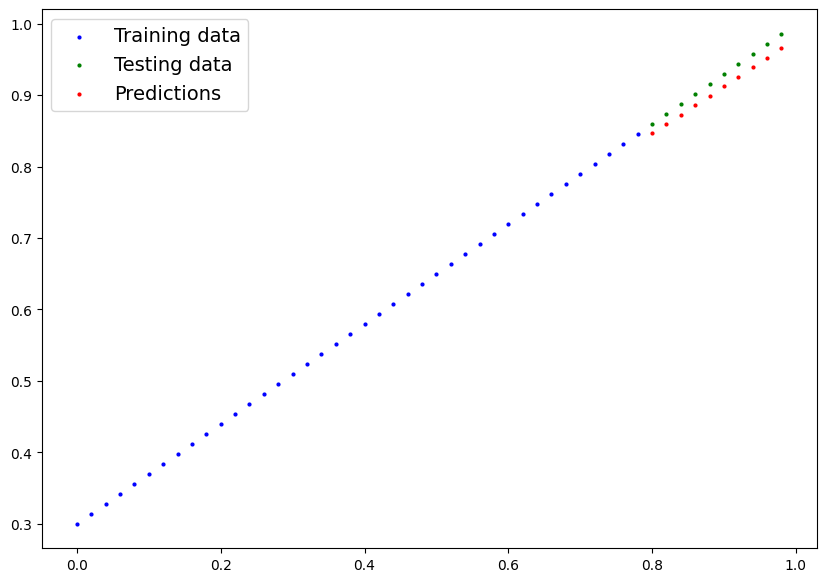

In [225]:
# Make predictions now
with torch.inference_mode():
    y_preds = model_0.forward(X_test)

# Plot
plot_predictions(predictions=y_preds)